# Kaggle Data Science and Machine Learning Survey for 2019

In [1]:
# Import libraries

import pandas as pd, numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid") # set some seaborn styles

In [2]:
# Import data

df_raw = pd.read_csv("../data_raw/multiple_choice_responses_2019.csv", low_memory=False)

In [3]:
# Data wrangling

df = df_raw.copy() 

# extract question
questions = df.iloc[0,:]

# drop questions
df = df.drop(df.index[0])

# check and drop duplicates
df = df.drop_duplicates()

# Dropping columns based on string pattern
drop_all = ["Q26", "Time from Start to Finish", "Q11", "Q19"]

for col in drop_all:
    df = df.loc[:,~df.columns.str.contains(col)]
    
rename = {"Q1" : "age",
          "Q2" : "gender",
          "Q3" : "country",
          "Q4" : "degree",
          "Q5" : "position",
          "Q6" : "company_size",
          "Q7": "team_size",
          "Q10": "salary"
          }
df = df.rename(columns=rename)

### Comparison between India and USA for specific Data Science related stats

In [4]:
def undummy(df, col_pattern, labels_only=False):
    df_tmp = df.loc[:,df.columns.str.contains(col_pattern)]
    cols_to_bool = list(df_tmp.columns)

    df_tmp = df_tmp.fillna(0)

    labels = []
    for col in cols_to_bool:
        labels.append(df_tmp[col].value_counts().keys()[1])


    for col in cols_to_bool:
        df_tmp[col] = np.where(df_tmp[col] != 0, 1, 0)
        df_tmp[col] = df_tmp[col].astype(int)

    resources = []
    for col in cols_to_bool:
        resources.append(df_tmp[col].sum())

    labels

    resources = pd.DataFrame(data=resources, index=labels)
#     resources = resources.drop("6")
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)
    
    if labels_only == True:
        return labels
    return resources

In [5]:
def undummy_single_col(df, col_name):
    sr_tmp = df[col_name]
    sr_tmp = sr_tmp.fillna(0)

    labels = sr_tmp.value_counts().keys().tolist()
    labels = pd.Series(labels).astype(str)
    labels = labels.str.replace("0", "None")

    resources = sr_tmp.value_counts().tolist()
    
    resources = pd.DataFrame(data=resources, index=labels)
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)

    return resources

In [6]:
def total_to_perc(df, df1, df2, col1, col2):
    df_perc = df
    df_perc = df_perc.drop(columns=[col1, col2])
    df_perc = df_perc.assign(india = df[col1].apply(lambda x: (x/len(df1))*100))
    df_perc = df_perc.assign(usa = df[col2].apply(lambda x: (x/len(df2))*100))
    return df_perc

In [7]:
# Some general figure size to use in the plots
figure_size = (12,6)

In [8]:
# Some function to calculate percentages
def perc(df, col):
    return round(100 * df[col].value_counts(normalize=True),2).to_frame()

## County sample distribution

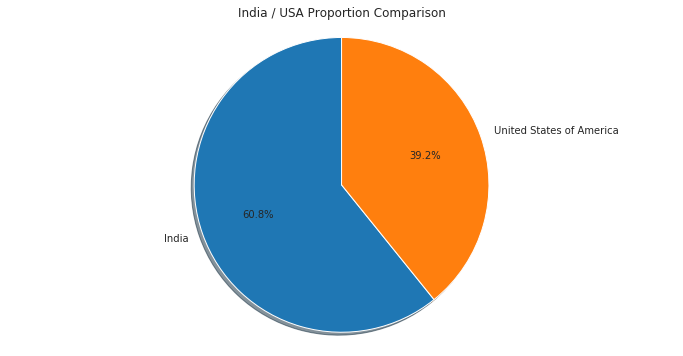

In [39]:
india = df[df["country"] == "India"]
usa = df[df["country"] == "United States of America"]

df_comp = df[(df["country"] == "India") | (df["country"] == "United States of America")].copy()
df_country = df_comp[["country"]]

labels = df_country["country"].value_counts().keys().tolist()
sizes = [len(india), len(usa)]

fig1, ax1 = plt.subplots(figsize=figure_size)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("India / USA Proportion Comparison")
plt.show()

## Gender sample distribution

In [10]:
global_gender_dist = perc(df, "gender").rename(columns={"gender" : "global"})
india_gender_dist = perc(india, "gender").rename(columns={"gender" : "india"})
usa_gender_dist = perc(usa, "gender").rename(columns={"gender" : "usa"})

df_gender = global_gender_dist.merge(right=india_gender_dist, how="inner", left_index=True, right_index=True)
df_gender= df_gender.merge(right=usa_gender_dist, how="inner", left_index=True, right_index=True)

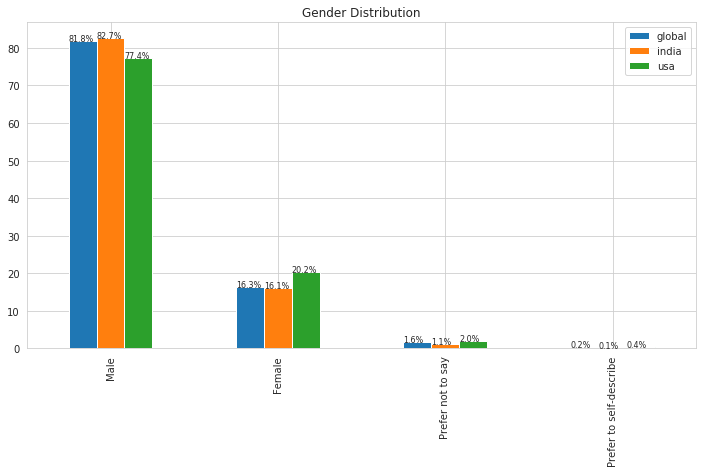

In [42]:
fig, ax = plt.subplots(figsize=figure_size)
df_gender.plot(kind="bar", ax=ax);

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=0, fontsize = 8)
    
ax.set_title("Gender Distribution");


## Age sample distribution

In [12]:
global_age_dist = perc(df, "age").rename(columns={"age" : "global"})
india_age_dist = perc(india, "age").rename(columns={"age" : "india"})
usa_age_dist = perc(usa, "age").rename(columns={"age" : "usa"})

df_age = global_age_dist.merge(right=india_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.merge(right=usa_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.reset_index()
df_age = df_age.rename(columns={"index": "age"}).sort_values(by="age")
df_age = df_age.set_index("age")

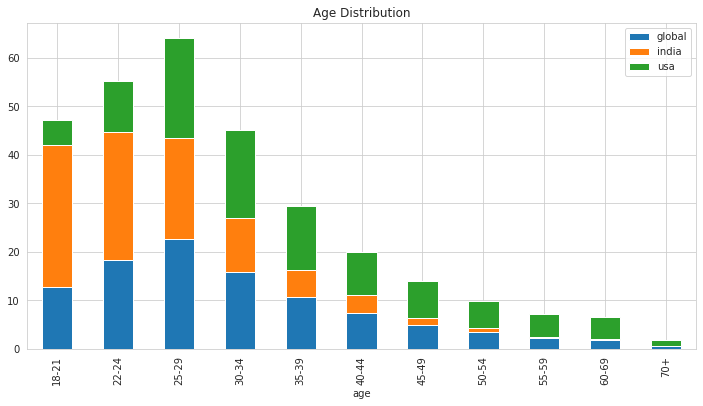

In [43]:
fig, ax = plt.subplots(figsize=figure_size)
df_age.plot(kind="bar", ax=ax, stacked=True);

ax.set_title("Age Distribution");


## Educational degree sample distribution

In [14]:
global_degree_dist = perc(df, "degree").rename(columns={"degree" : "global"})
india_degree_dist = perc(india, "degree").rename(columns={"degree" : "india"})
usa_degree_dist = perc(usa, "degree").rename(columns={"degree" : "usa"})

df_degree = global_degree_dist.merge(right=india_degree_dist, how="inner", left_index=True, right_index=True)
df_degree = df_degree.merge(right=usa_degree_dist, how="inner", left_index=True, right_index=True)

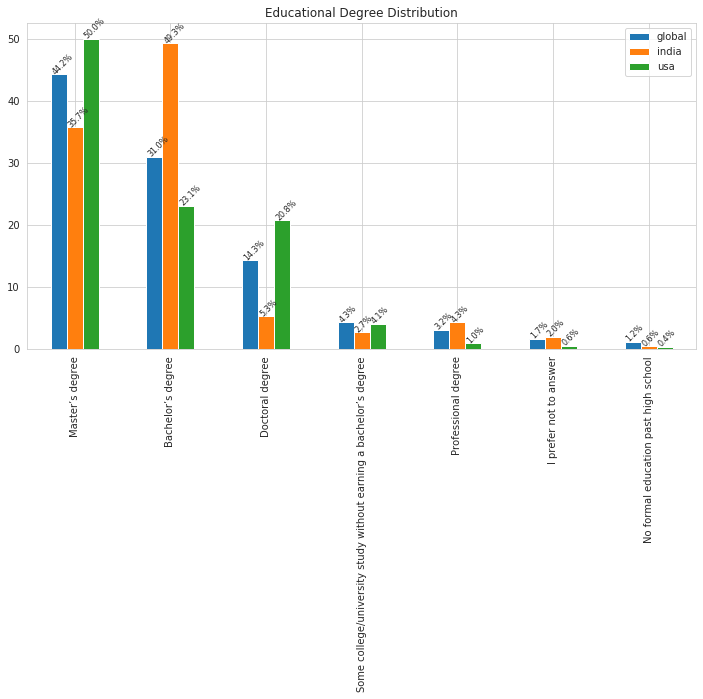

In [44]:
ax = df_degree.plot(kind="bar", figsize=figure_size);

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)
    
ax.set_title("Educational Degree Distribution");


## Position

In [16]:
global_position_dist = perc(df, "position").rename(columns={"position" : "global"})
india_position_dist = perc(india, "position").rename(columns={"position" : "india"})
usa_position_dist = perc(usa, "position").rename(columns={"position" : "usa"})

df_position = global_position_dist.merge(right=india_position_dist, how="inner", left_index=True, right_index=True)
df_position = df_position.merge(right=usa_position_dist, how="inner", left_index=True, right_index=True)

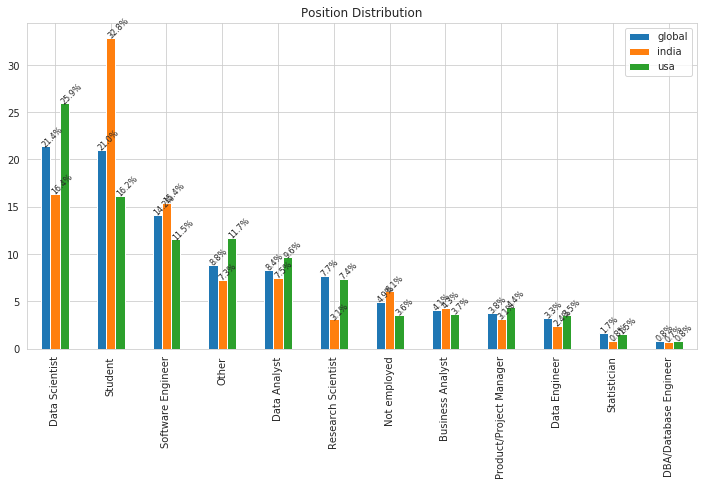

In [45]:
ax = df_position.plot(kind="bar", figsize=figure_size);

for i in ax.patches:
    ax.text(i.get_x(),i.get_height(), str(round((i.get_height()), 1))+"%", rotation=45, fontsize = 8)

ax.set_title("Position Distribution");


## Salary

In [18]:
global_salary_dist = perc(df, "salary").rename(columns={"salary" : "global"})
india_salary_dist = perc(india, "salary").rename(columns={"salary" : "india"})
usa_salary_dist = perc(usa, "salary").rename(columns={"salary" : "usa"})

df_salary = global_salary_dist.merge(right=india_salary_dist, how="inner", left_index=True, right_index=True)
df_salary = df_salary.merge(right=usa_salary_dist, how="inner", left_index=True, right_index=True)
df_salary = df_salary.reset_index().rename(columns={"index" : "salary"}).sort_values("salary").set_index("salary")
df_salary = df_salary.reindex(index = ["$0-999", "1,000-1,999", "2,000-2,999",  "3,000-3,999", "4,000-4,999", 
                                       "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999", "20,000-24,999", 
                                       "25,000-29,999", "30,000-39,999", "40,000-49,999", "50,000-59,999", 
                                       "60,000-69,999", "70,000-79,999", "80,000-89,999", "90,000-99,999", 
                                       "100,000-124,999", "125,000-149,999", "150,000-199,999", "200,000-249,999",
                                       "250,000-299,999", "300,000-500,000", "> $500,000"])

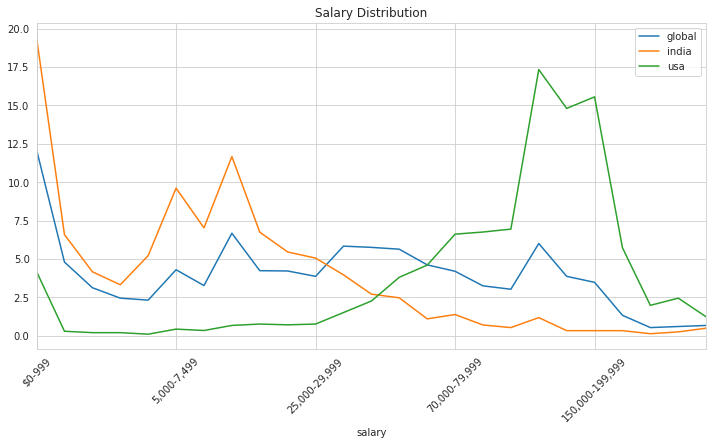

In [46]:
df_salary.plot(kind="line", figsize=figure_size, rot=45).set_title("Salary Distribution");


## Company size

In [20]:
global_company_size_dist = perc(df, "company_size").rename(columns={"company_size" : "global"})
india_company_size_dist = perc(india, "company_size").rename(columns={"company_size" : "india"})
usa_company_size_dist = perc(usa, "company_size").rename(columns={"company_size" : "usa"})

df_company_size = global_company_size_dist.merge(right=india_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.merge(right=usa_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.reset_index().rename(columns={"index" : "company_size"}).sort_values("company_size").set_index("company_size")
df_company_size = df_company_size.reindex(index = ["0-49 employees", "50-249 employees", "250-999 employees", "1000-9,999 employees", "> 10,000 employees"])


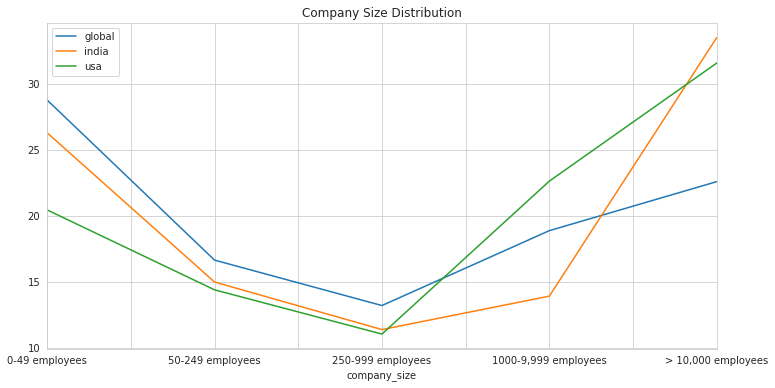

In [47]:
df_company_size.plot(kind="line", figsize=figure_size).set_title("Company Size Distribution");

## Programming languages

In [22]:
languages_india = undummy(india, "Q18")
languages_india = languages_india.drop("2", axis=0)
languages_india = languages_india.rename(index={0: "Python"})
languages_usa = undummy(usa, "Q18")
languages_usa = languages_usa.drop("2", axis=0)
languages_usa = languages_usa.rename(index={0: "Python"})

languages = languages_india.merge(right=languages_usa, how="inner", left_index=True, right_index=True)
languages = languages.rename(columns={"value_x": "india", "value_y": "usa"})

languages_perc = total_to_perc(languages, india, usa, "india", "usa")

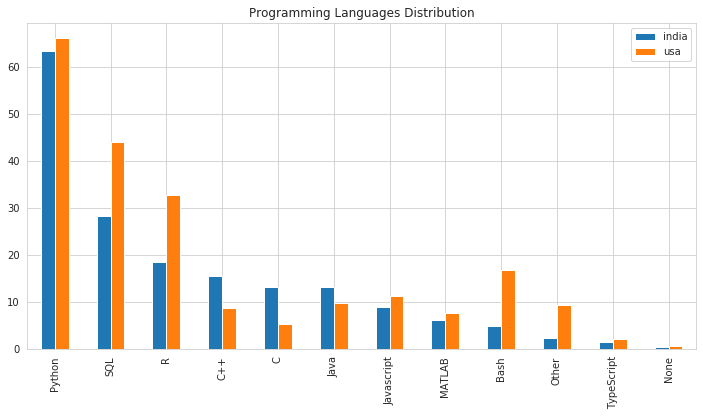

In [49]:
# programming languages percentages
fig, ax = plt.subplots(figsize=figure_size)
languages_perc.plot(kind="bar", ax=ax)

ax.set_title("Programming Languages Distribution");
plt.show()


## Programming experience

In [24]:
india_exp_dist = perc(india, "Q15").rename(columns={"Q15": "india"})
usa_exp_dist = perc(usa, "Q15").rename(columns={"Q15": "usa"})
df_exp = india_exp_dist.merge(right=usa_exp_dist, how="inner", left_index=True, right_index=True)
df_exp = df_exp.reindex(["I have never written code", "< 1 years", "1-2 years", "3-5 years", "5-10 years", "10-20 years", "20+ years"])

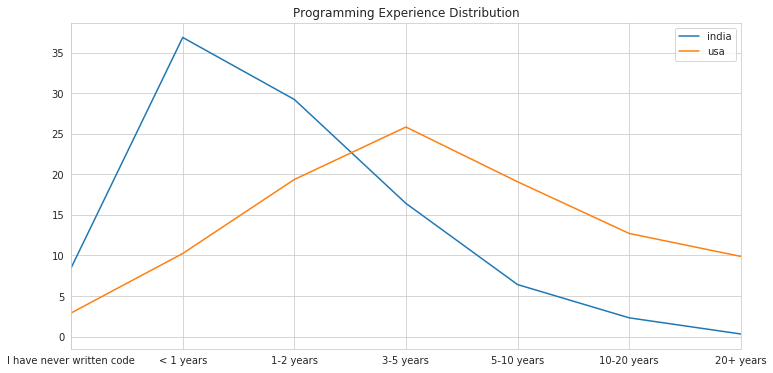

In [50]:
# programming experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp.plot(kind="line", ax=ax)

ax.set_title("Programming Experience Distribution");
plt.show()

## Machine Learning experience

In [26]:
india_exp_ml_dist = perc(india, "Q23").rename(columns={"Q23": "india"})
usa_exp_ml_dist = perc(usa, "Q23").rename(columns={"Q23": "usa"})
df_exp_ml = india_exp_ml_dist.merge(right=usa_exp_dist, how="inner", left_index=True, right_index=True)

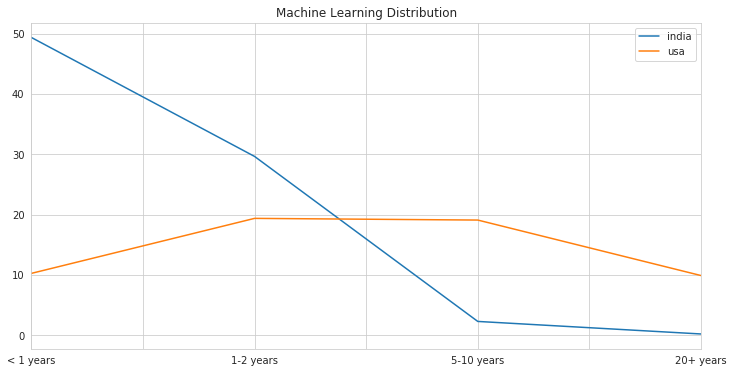

In [51]:
# machine learning experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp_ml.plot(kind="line", ax=ax)

ax.set_title("Machine Learning Distribution");
plt.show()

## Machine learning methods

In [28]:
ml_tools_india = undummy(india, "Q24")
ml_tools_india = ml_tools_india.rename(index={0: "Linear or Logistic Regression"})
ml_tools_usa = undummy(usa, "Q24")
ml_tools_usa = ml_tools_usa.rename(index={0: "Linear or Logistic Regression"})

ml_tools = ml_tools_india.merge(right=ml_tools_usa, how="inner", left_index=True, right_index=True)
ml_tools = ml_tools.rename(columns={"value_x": "india", "value_y": "usa"})
ml_tools = ml_tools.drop("1", axis=0)

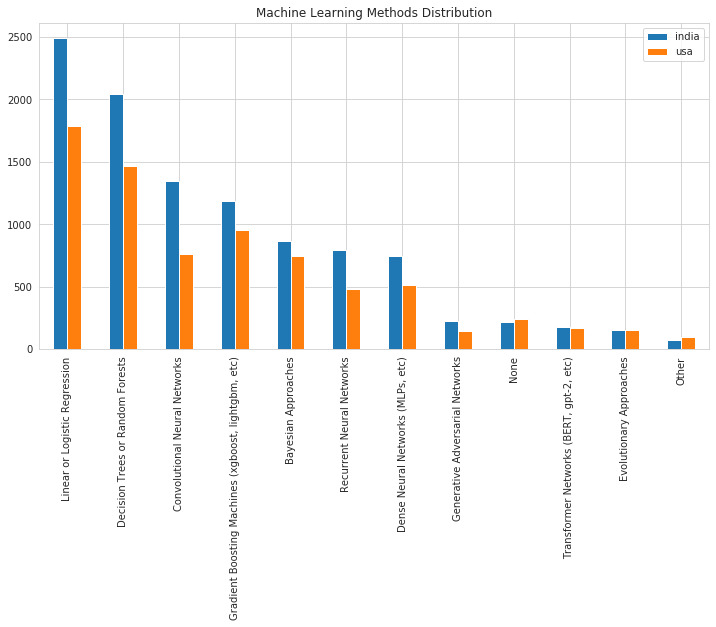

In [52]:
# machine learning tools total numbers
fig, ax = plt.subplots(figsize=figure_size)
ml_tools.plot(kind="bar", ax=ax)

ax.set_title("Machine Learning Methods Distribution");
plt.show()

## Learning Resources

In [30]:
resources_india = undummy(india, "Q13")
resources_usa = undummy(usa, "Q13")

resources = resources_india.merge(right=resources_usa, how="inner", left_index=True, right_index=True)
resources = resources.rename(columns={"value_x": "india", "value_y": "usa"})

resources_perc = total_to_perc(resources, india, usa, "india", "usa")

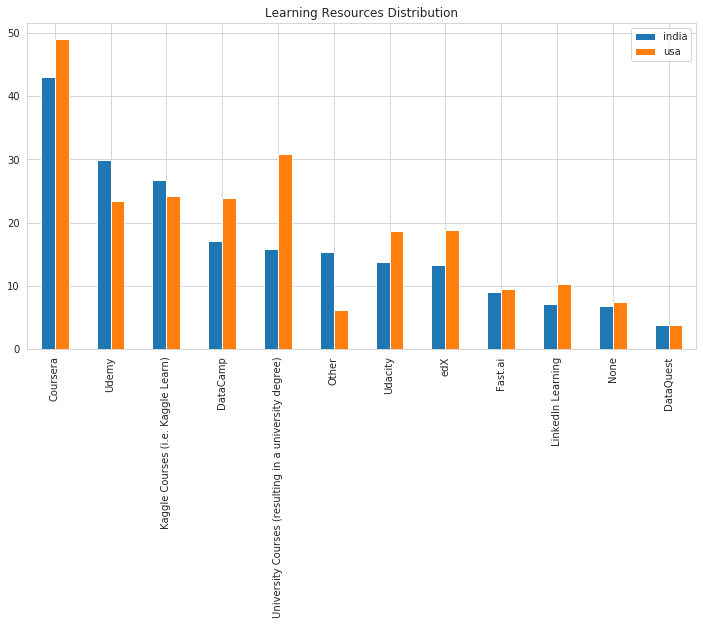

In [53]:
# learning resources percentages
fig, ax = plt.subplots(figsize=figure_size)
resources_perc.plot(kind="bar", ax=ax)

ax.set_title("Learning Resources Distribution");
plt.show()